# Shot noise sim from ALFALFA LF

This is the luminosity function partner to the analysis of the HIMF.

In [83]:
%matplotlib inline
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt

Toggle code

Take Schechter function parameters from Moorman et al. 2015. Explore magnitude range from -22 to -14.

In [84]:
phi, mstar, alpha = 10**(-4.43), -20.74, -1.2

x = np.linspace(-22.2, -13.8, 240000)

Take the definition of the Schechter function from Moorman.

In [78]:
#mf = phi * (x / mstar)**(1 + alpha) * np.exp(-x / mstar) / (-1 - alpha)
mf = 0.4*np.log(10) * phi * 10**(0.4*(-x + mstar)*(alpha + 1)) *\
         np.exp(-10**(0.4*(-x + mstar)))

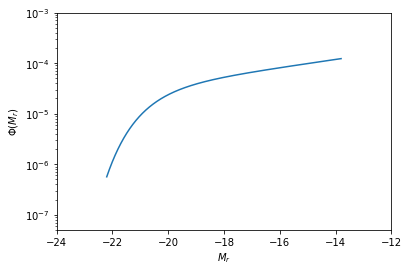

In [79]:
plt.plot(x, mf)
plt.xlim([-24., -12.])
plt.ylim([5e-8, 1e-3])
plt.yscale('log')
plt.xlabel('$M_r$')
plt.ylabel('$\Phi(M_r)$')
plt.show()

Now we choose mass bins over which we'll integrate the function to return the number density of galaxies for each bin. We'll choose 25 bins to model Martin et al.

In [80]:
bins = np.linspace(-22, -14, 26)
nbin = np.ones_like(bins[:-1])
cent = np.ones_like(bins[:-1])

for bb in range(len(bins)-1):
    cent[bb] *= (bins[bb] + bins[bb+1]) / 2.
    mask = (x<bins[bb+1])    
    #mask = (x>=bins[bb]) & (x<bins[bb+1])
    nbin[bb] *= (integrate.simps(mf[mask], x[mask]))  
    
nbar = integrate.simps(mf, x)
mfint = np.array(nbin)

Integrating the LF from $M_{r} \sim -22 $ to $M_{r} \sim -12$ gives $\bar{n} \sim 6.0\times 10^{-3}$ for the ALFALFA "Walls" Schechter function, and $\bar{n} \sim 4.5\times 10^{-3}$ for "Voids".